<a href="https://colab.research.google.com/github/ekmungi/ml_examples/blob/master/pytorch_cnn_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing what convnets learn

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os, random, pathlib

from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as datasets
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Reshape, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications  import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras import models

In [3]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   rescale=1./255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   horizontal_flip=True)#,
                                   #fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)


batch_size = 32


train_generator = train_datagen.flow_from_directory(
    '/home/anant/data/Kaggle/Fruit360/Training/',  # this is the target directory
    target_size=(100, 100),  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    '/home/anant/data/Kaggle/Fruit360/Test/',  # this is the target directory
    target_size=(100, 100),  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='categorical')

Found 59328 images belonging to 118 classes.
Found 20232 images belonging to 118 classes.


In [95]:
def get_activations_and_model(model, index, image):
    layer_outputs = [layer.output for layer in model.layers[:index]]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(image)
    if isinstance(activations, np.ndarray):
        activations = list(activations)
    return activation_model, activations

In [66]:
def get_layer_names(layers, verbose=False):
    layer_names = []
    for layer in layers:
        layer_names.append(layer.name)
    if verbose:
        print(layer_names)
        
    return layer_names
    

In [90]:
def plot_activations(layer_names, activations, images_per_row=16):

    for layer_name, layer_activation in zip(layer_names, activations):
        
        if len(layer_activation.shape) < 4:
            layer_activation = np.expand_dims(layer_activation, 0)

        n_features = layer_activation.shape[-1]
        feature_map_size = layer_activation.shape[1] # n_batches x feature_map_size x feature_map_size x n_features

        n_rows = n_features // images_per_row

        display_grid = np.zeros((feature_map_size*n_rows, images_per_row*feature_map_size))

        for row in range(n_rows):
            for col in range(images_per_row):
                
                channel_image = layer_activation[0,:,:,row*images_per_row + col]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')

                display_grid[row*feature_map_size : (row+1)*feature_map_size,
                             col*feature_map_size : (col+1)*feature_map_size] = channel_image


        scale = 1./feature_map_size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))

        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
    

In [6]:
model_paths = ['/media/anant/data/Kaggle/Fruit360/models/vgg16_frozen_after_pretraining_last_few_conv_layers.h5',
               '/media/anant/data/Kaggle/Fruit360/models/vgg16_frozen_full_trained.h5',
               '/media/anant/data/Kaggle/Fruit360/models/vgg16_unfrozen_last_few_conv_layers_trained.h5',
               '/media/anant/data/Kaggle/Fruit360/models/custom_cnn_trained.h5']

(32, 100, 100, 3) (32, 118)


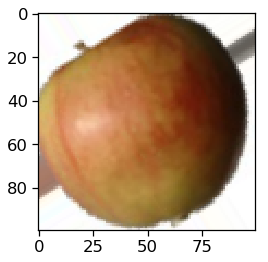

In [68]:
SELECTED_IMAGE = 1
img, label = train_generator[10]
print(img.shape, label.shape)
plt.imshow(img[SELECTED_IMAGE,:,:,:].squeeze())
image = np.expand_dims(img[SELECTED_IMAGE,:,:,:], 0)

In [69]:
SELECTED_MODEL = 3
print('Selected model: {0}'.format(model_paths[SELECTED_MODEL]))
model = load_model(model_paths[SELECTED_MODEL])
model.summary()

Selected model: /media/anant/data/Kaggle/Fruit360/models/custom_cnn_trained.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________

In [96]:
MODEL_LAYER_INDEX = 9
activation_model, activations = get_activations_and_model(model, MODEL_LAYER_INDEX, image)

['conv2d', 'max_pooling2d', 'conv2d_1', 'dropout_2', 'max_pooling2d_1', 'conv2d_2', 'dropout_3', 'max_pooling2d_2', 'conv2d_3']


/home/anant/anaconda3/envs/TF/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


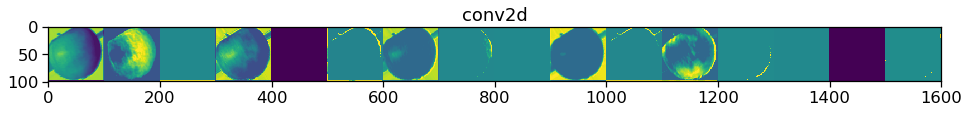

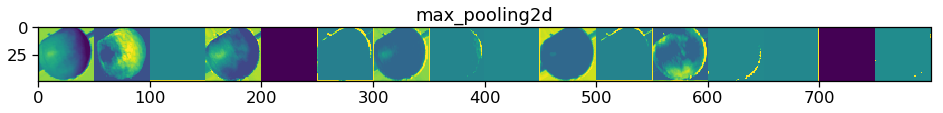

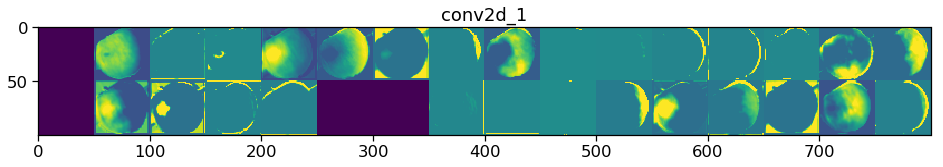

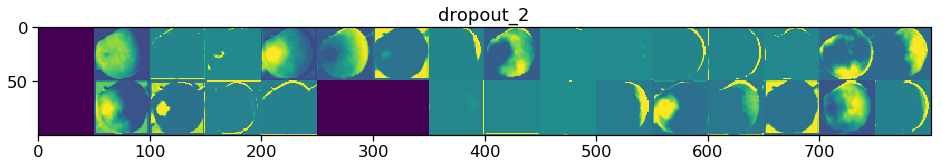

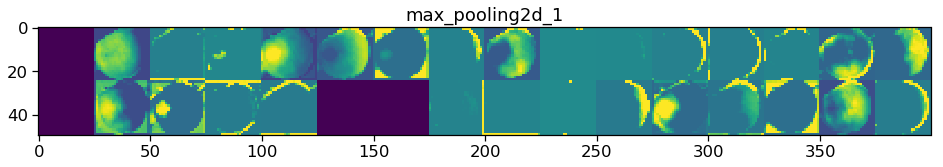

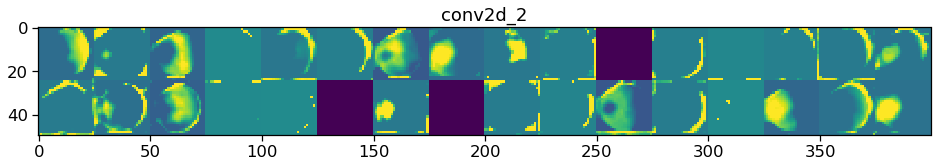

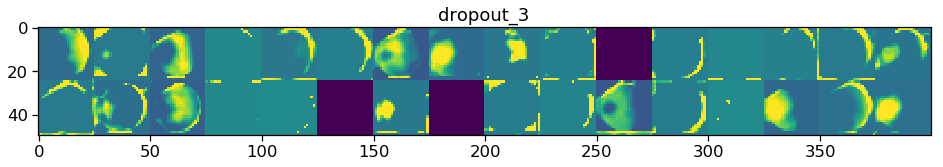

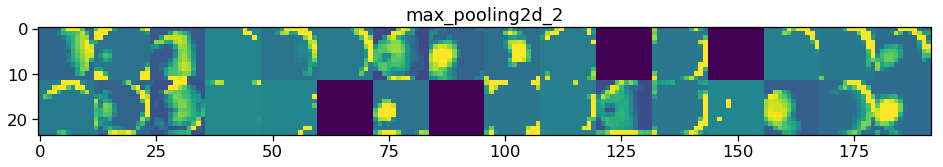

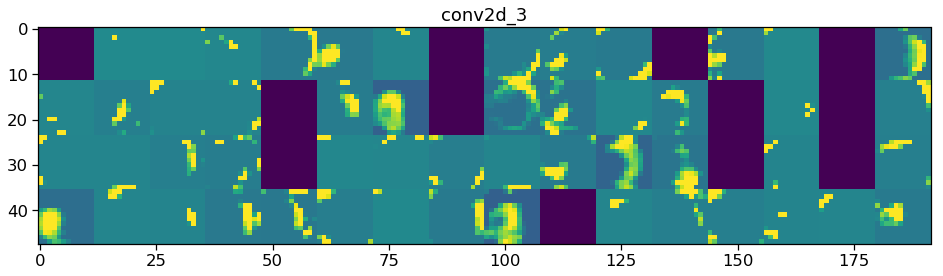

In [97]:
layer_names = get_layer_names(model.layers[:MODEL_LAYER_INDEX], verbose=True)
plot_activations(layer_names, activations, images_per_row=16)